# A minimal example, showing how the KAE EnKF could be used in practice

In [25]:
!python -V

Python 3.7.6


In [13]:
#Copy this script and then edit to make specific to your dataset for parameter tweaking
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from scipy.sparse.linalg import svds

#Set matplotlib settings as required
%matplotlib inline
scaling = 1.6
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from libraries.KAE import KoopmanAE, LuschLoss
from libraries.DMDEnKF import EnKF
import simple_sin_helpers as ssf

### Generate example synthetic data with a time varying eigenvalue argument's trajectory and plot

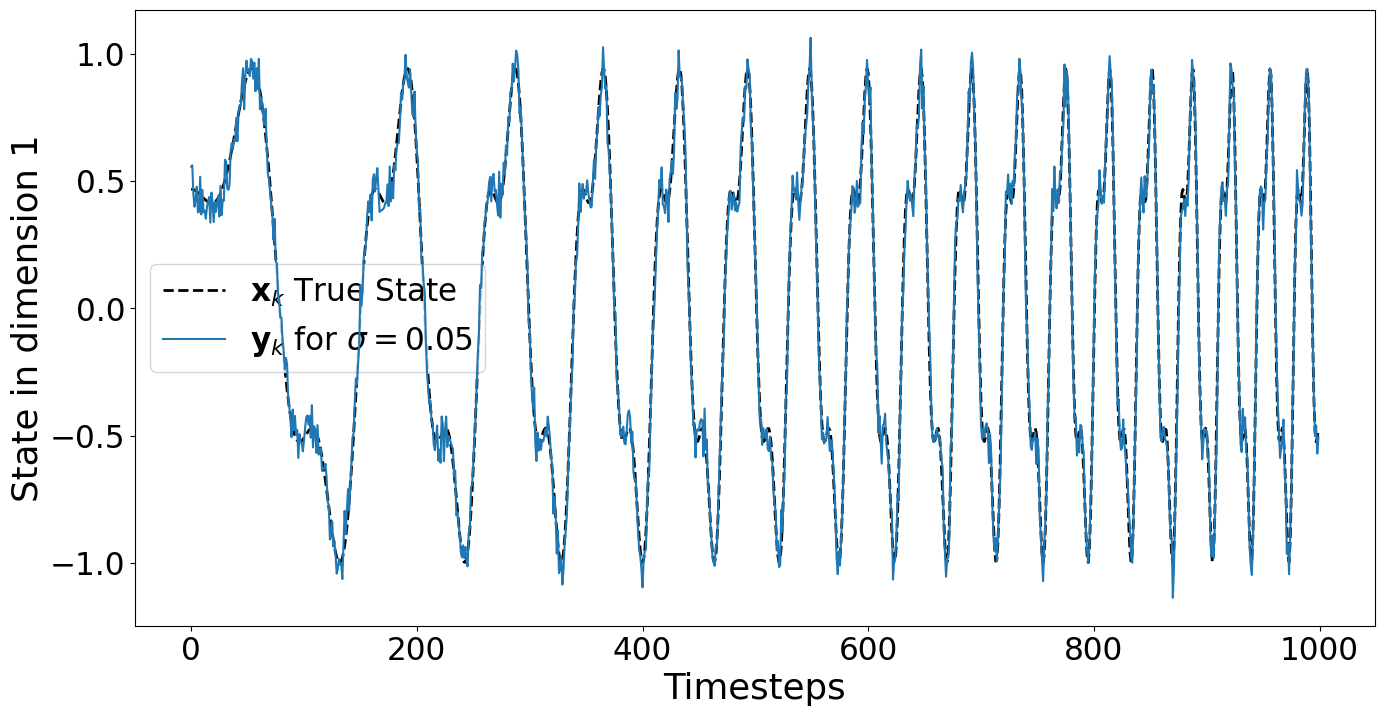

In [14]:
#example noise data plot

#data generation parameters
num_data = 1000
num_spinup = 200
theta_start = np.pi/128
theta_end = np.pi/16
r_start = 1
r_end = 1
obs_cov = 0.05**2
data_dim = 100
power = 3    #Governs the degree of nonlinearity in the system

#Random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
#dataset and dataloaders
dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)

#Plot the true state, alongside the low/high noise generated measurements
plt.plot(dataset.true_highdim_data.T[0], label =r'$\mathbf{x}_k$ True State',alpha = 1, linewidth='2', ls='--',color='black')
plt.plot(dataset.data.T[0],alpha=1, color='tab:blue',zorder=10,label=r'$\mathbf{y}_k$ for $\sigma = 0.05$')
plt.xlabel('Timesteps')
plt.ylabel('State in dimension 1')
plt.legend()

### Setup KAE, architecture, dataloaders, optimiser etc

In [15]:
#standard setup, needed to be done before parameter tweaking to ensure all vars set correctly

#ALL KAE EnKF PARAMETERS

#KAE variables
input_size = data_dim    #measurement dimension
num_frequencies = 1    #Number of frequencies inside the model
intermid_size = 10    #encoder/decoder hidden layer dimensions

#Create KAE encoder/decoder network architectures
encoder_module_list = nn.ModuleList([nn.Linear(input_size,intermid_size),nn.ReLU(),
                                     nn.Linear(intermid_size,intermid_size),nn.ReLU(),
                                     nn.Linear(intermid_size,num_frequencies*2)])
decoder_module_list = nn.ModuleList([nn.Linear(num_frequencies*2,intermid_size),nn.ReLU(),
                                     nn.Linear(intermid_size,intermid_size),nn.ReLU(),
                                     nn.Linear(intermid_size,input_size)])

#training parameters
batch_size = 64
epochs = 100
global_fourier_interval = 10
print_interval = 10

#dataset and dataloaders
#Note: dataloader only draws data from inside the spin-up indices
train_dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
#No validation set for this example, however one can be added simply as required
val_dataloader = None

#initialise Koopman AE, loss function and optimiser and attatch them to the KAE class
kae = KoopmanAE(input_size,num_frequencies,encoder_module_list,decoder_module_list)
lossfunc = LuschLoss
#this is a variable used for setting weightings of loss function components (a1,a2,a3,a4,a5)
#standard, linear, reconstruction, amplitude stability, regularisation
loss_hyperparameters = [1,1,1,1,0.01]
opt = optim.AdamW(kae.parameters(),lr=0.01)
'''No svd init used in this example, however it can be added simplay via the svd_init argument'''
#U, _, _ = svds(np.array(dataset.spinup_data).T,k=intermid_size)
#U = torch.from_numpy(U.astype(np.float32).copy())
kae.set_training_attributes(opt,lossfunc,loss_hyperparameters,train_dataloader,val_dataloader=val_dataloader,svd_init=None)

#Move to GPU (sadly needed to be done this way for JIT compiler compatibility)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
kae = kae.to(dev)
kae.device = dev
kae.linear_koopman_layer.device = dev

### Run KAE training loop

In [16]:
#TRAINING LOOP
kae.run_training_loop(epochs,global_fourier_interval=global_fourier_interval,print_interval=print_interval)

0
tensor([1.])
tensor([0.6993])
First Choice: 0.25160697559339834
New Frequency: 0.25160697559339834
Train Loss: 1.9086424112319946
10
tensor([1.0009])
tensor([-0.0038])
Train Loss: 0.6581967920064926
First Choice: 6.265712600541156
New Frequency: 6.265712600541156
20
tensor([0.9981])
tensor([6.2862])
Train Loss: 0.2593311741948128
First Choice: 0.06290174389834959
New Frequency: 0.06290174389834959
30
tensor([0.9986])
tensor([0.0433])
Train Loss: 0.24158231914043427
First Choice: 0.04892357858760523
New Frequency: 0.04892357858760523
40
tensor([1.0021])
tensor([0.0466])
Train Loss: 0.21403809636831284
50
tensor([0.9980])
tensor([0.0409])
Train Loss: 0.10734360106289387
First Choice: 0.04193449593223306
New Frequency: 0.04193449593223306
60
tensor([0.9983])
tensor([0.0343])
Train Loss: 0.0914806742221117
70
tensor([1.0024])
tensor([0.0372])
Train Loss: 0.07878982834517956
First Choice: 0.04542903725991914
New Frequency: 0.04542903725991914
80
tensor([0.9988])
tensor([0.0443])
Train Los

### Feed the KAE trained on the spin-up data into the EnKF, as described in the KAE EnKF paper, and filter the remaining data

In [20]:
#KAE EnKF Filter section run - hence run over all subsequent data after the spin-up phase
sys_cov_const = 0.05**2
param_cov_consts = np.array([0.0005**2,0.005**2])
obs_cov_const = obs_cov
init_cov_const = obs_cov_const

#The kaeenkf instance returned here is the enkf result over the data after the spin-up phase
kaeenkf = ssf.apply_kae_enkf_filter(kae,dataset.filter_data,sys_cov_const,param_cov_consts,obs_cov_const,init_cov_const,ensemble_size = 100)

#kaeenkf.X represents the filters state at each timestep,
#hence the system's latent state followed by any parameters being filtered

### Plot eigenvalue modulus and argument estimates from each modelling method

Text(0, 0.5, 'Eigenvalue Modulus')

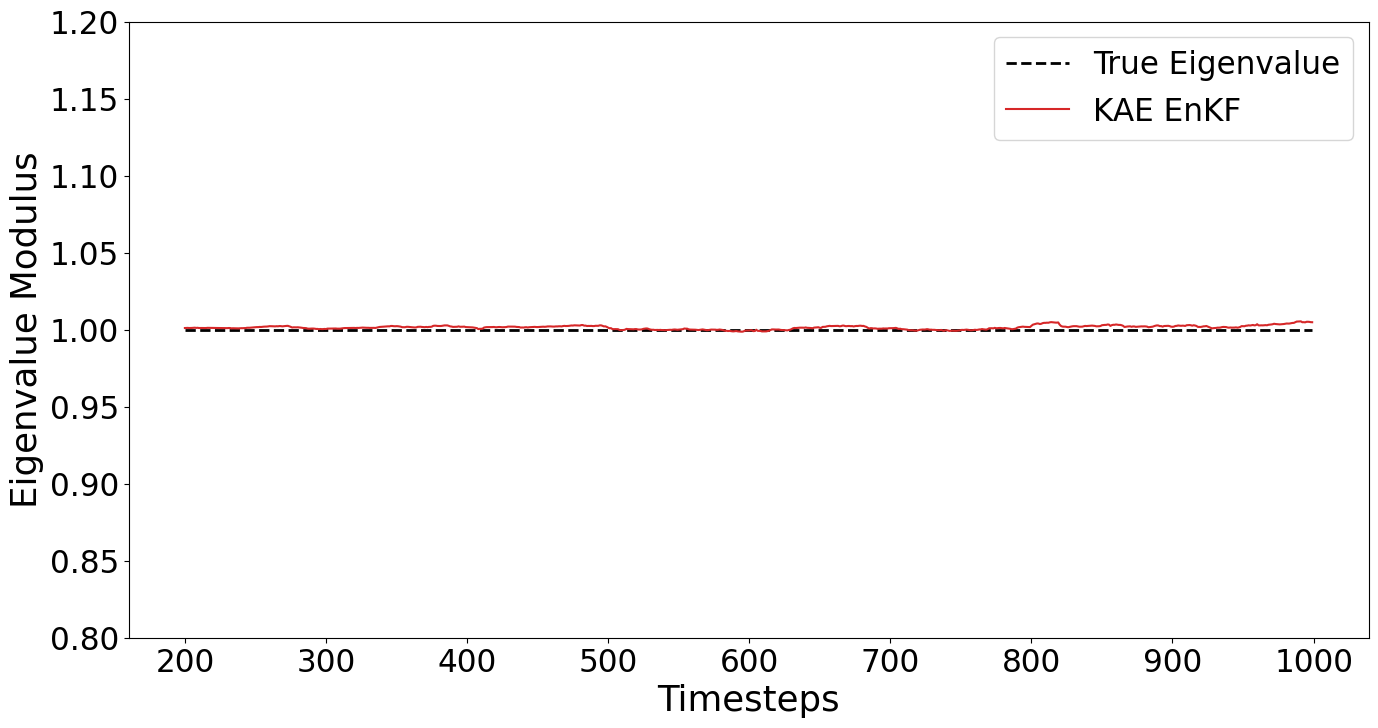

In [18]:
#View the eignevalue modulus predictions for each method

num_to_keep = num_data-num_spinup
x = range(200,1000)
plt.plot(x,np.ones(num_to_keep),label='True Eigenvalue',c='black',linewidth='2', ls='--',zorder=3)
plt.plot(x,[x[-2] for x in kaeenkf.X][-num_to_keep:],label='KAE EnKF',c='tab:red',zorder=3)
plt.legend()
plt.ylim(0.8, 1.2)
plt.xlabel('Timesteps')
plt.ylabel('Eigenvalue Modulus')
#plt.savefig('graphs/0.05_edmd_eigmod_trajectory.png',bbox_inches='tight')

Text(0, 0.5, 'Eigenvalue Argument')

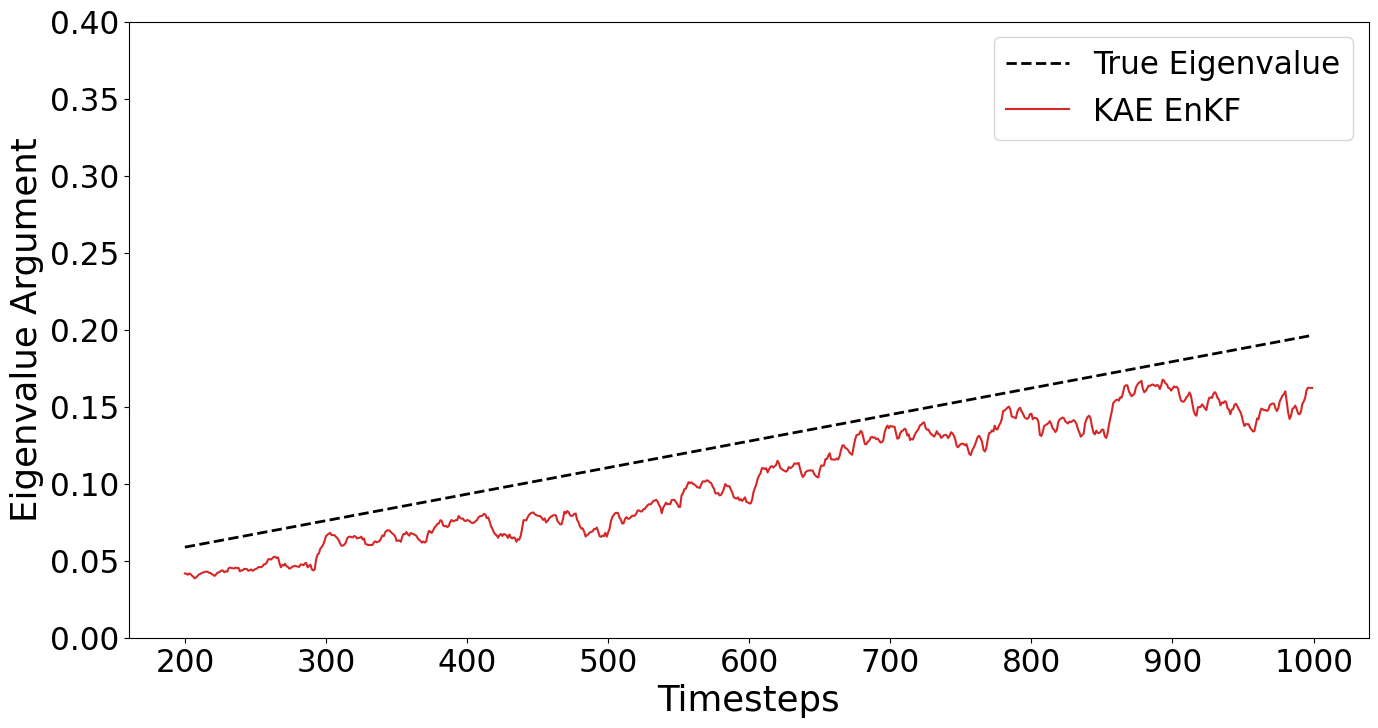

In [19]:
#View the eignevalue argument predictions for each method
num_to_keep = num_data-num_spinup
plt.plot(x,dataset.thetas[-num_to_keep:],c='black',linewidth='2', ls='--',zorder=1,label='True Eigenvalue')
plt.plot(x,[abs(2*np.pi - x[-1]) if x[-1]>np.pi else x[-1] for x in kaeenkf.X][-num_to_keep:],
         label='KAE EnKF', c='tab:red',zorder=3)
plt.legend()
plt.ylim(0, 0.4)
plt.xlabel('Timesteps')
plt.ylabel('Eigenvalue Argument')
#plt.savefig('graphs/0.05_edmd_eigarg_trajectory.png',bbox_inches='tight')